# predicting model of slaking settlement¶
## import and definition

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import math 
import numpy.polynomial.polynomial as poly
from scipy.interpolate import interp1d
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.patches as patches
# calculating the brekage 
def relative_br (seive_size, percentage_passing):

    seive_log=np.log10(np.array(seive_size))
    seive_dis=np.array(seive_log)[:-1]-np.array(seive_log)[1:]
    per_dis_100_1cy=(np.array(percentage_passing)[:-1]+np.array(percentage_passing)[1:])/2
    total_100_1cy=((seive_dis)*per_dis_100_1cy).sum()
    seive_dis_init=(np.log10(np.array(seive_size)[0])-np.log10(np.array(seive_size)[1]))*50
    area_inbetween=total_100_1cy-seive_dis_init
    possible_total=(np.log10(np.array(seive_size)[0])-np.log10(np.array(seive_size)[-1]))*100-seive_dis_init
    Br=(area_inbetween/possible_total)
    return (Br)
# calculating the particle size with givein percentage
def parti_size (sei, pass_per, wan_per):
    return(np.interp(wan_per,list(reversed(list(pass_per))),list(reversed(list(sei)))))
def get_sub(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s))
    return x.translate(res)

# Data and its manipulation

In [70]:
df1= pd. read_excel (r"C:\Users\ThinkCentre-M73\Desktop\master 2\master research1.xlsx")#read the settlement related file
# df2= pd. read_excel (r"C:\Users\ThinkCentre-M73\Desktop\master 2\python link file\breakage.xlsx")#read the breakage related file
df3= pd. read_excel (r"C:\Users\ThinkCentre-M73\Desktop\master 2\python link file\3 compaction strain.xlsx")# 3 compaction mudstone
df1.dropna(subset = ["100 kpa"], inplace=True)


# add columen for dry density (no suffi)
df1["Dry Density 100 kpa"]=1250*(100)/(100-df1["100 kpa"]-1)
df1["Dry Density 200 kpa"]=1250*(100)/(100-df1["200 kpa"]-2.2)
df1["Dry Density 500 kpa"]=1250*(100)/(100-df1["500 kpa"]-4)
# compaction 
df3["Dry Density 82%"]=1314*(100)/(100-df3["s-82%"]-1.9)
df3["Dry Density 87%"]=1394*(100)/(100-df3["s-87%"]-1.0)

# add columen for voids (no suffi)
df1["e-100 kpa"]=(1-(df1["Dry Density 100 kpa"]/2690))/(df1["Dry Density 100 kpa"]/2690)
df1["e-200 kpa"]=(1-(df1["Dry Density 200 kpa"]/2690))/(df1["Dry Density 200 kpa"]/2690)
df1["e-500 kpa"]=(1-(df1["Dry Density 500 kpa"]/2690))/(df1["Dry Density 500 kpa"]/2690)
# compaction 
df3["e-82%"]=(1-(df3["Dry Density 82%"]/2690))/(df3["Dry Density 82%"]/2690)
df3["e-87%"]=(1-(df3["Dry Density 87%"]/2690))/(df3["Dry Density 87%"]/2690)
# add columen for voids (suffi)
df1['e-100 kpa'][0]=1.14229
df1['e-200 kpa'][0]=1.105
df1['e-500 kpa'][0]=1.02
# add columen for relative compaction 
df1['dc-100']=df1['Dry Density 100 kpa']/1650*100
df1['dc-200']=df1['Dry Density 200 kpa']/1650*100
df1['dc-500']=df1['Dry Density 500 kpa']/1650*100

In [68]:
df1["e-100 kpa"]

0     1.142290
1     0.505655
2     0.489358
3     0.486537
4     0.476412
5     0.476412
6     0.468933
7     0.468933
8     0.464032
9     0.463723
10    0.460297
11    0.459984
12    0.457778
13    0.457462
14    0.456828
15    0.455555
16    0.456510
17    0.455714
18    0.456319
19    0.455701
Name: e-100 kpa, dtype: float64


## rearranging the data only for dry

In [51]:
#only dry and not for first wetting 
#100
t0_100=np.array(df1['e-100 kpa'][::2])#e for dry 
t1_100=t0_100-np.ones(len(t0_100))*t0_100[-1]#differnce from nc line
t2_100=t0_100[:-1]-t0_100[1:]                # e reduction
# e_cum_100=np.cumsum(t1_100)# cumulative differnce from nc line
s_cum_100=np.array(df1["100 kpa"][::2])# cumulative dry strain
s1_100=-(s_cum_100[:-1]-s_cum_100[1:])[:]#strain by cycle
#200
t0_200=np.array(df1['e-200 kpa'][::2])#e
t1_200=t0_200-np.ones(len(t0_200))*t0_200[-1]#differnce from nc line
t2_200=t0_200[:-1]-t0_200[1:]                 # e reduction
# e_cum_200=np.cumsum(t1_200)# cumulative differnce from nc line
s_cum_200=np.array(df1["200 kpa"][::2])# cumulative dry strain
s1_200=-(s_cum_200[:-1]-s_cum_200[1:])[:]#strain by cycle
# #compaction 
#82%
t0_82=np.array(df3['e-82%'][::2])#e
t1_82=t0_82-np.ones(len(t0_82))*t0_200[-1]#differnce from nc line
t2_82=t0_82[:-1]-t0_82[1:]
e_cum_82=np.cumsum(t1_82)# cumulative differnce from nc line
s_cum_82=np.array(df3["s-82%"][::2])# cumulative dry strain
s1_82=-(s_cum_82[:-1]-s_cum_82[1:])[:]
#87%
t0_87=np.array(df3['e-87%'][::2])#e
t1_87=t0_82-np.ones(len(t0_87))*t0_200[-1]#differnce from nc line
t2_87=t0_87[:-1]-t0_87[1:]
e_cum_87=np.cumsum(t1_87)# cumulative differnce from nc line
s_cum_87=np.array(df3["s-87%"][::2])# cumulative dry strain
s1_87=-(s_cum_87[:-1]-s_cum_87[1:])[:]
#500
t0_500=np.array(df1['e-500 kpa'][::2])#e
t1_500=t0_500-np.ones(len(t0_500))*t0_500[-1]#differnce from nc line
t2_500=t0_500[:-1]-t0_500[1:]
# e_cum_500=np.cumsum(t1_500)# cumulative differnce from nc line
s_cum_500=np.array(df1["500 kpa"][::2])# cumulative dry strain
s1_500=-(s_cum_500[:-1]-s_cum_500[1:])[:]

In [52]:
t0_87,t0_82

(array([0.91040172, 0.76470947, 0.73576399, 0.70681851]),
 array([1.00828767, 0.83018265, 0.78923896, 0.76262557]))

In [73]:
t0_100

array([1.14229  , 0.95832  , 0.9099   , 0.883    , 0.865784 , 0.852872 ,
       0.844264 , 0.841036 , 0.83996  , 0.8393144])

In [74]:
t2_100

array([0.18397  , 0.04842  , 0.0269   , 0.017216 , 0.012912 , 0.008608 ,
       0.003228 , 0.001076 , 0.0006456])

array([0.3029756, 0.1190056, 0.0705856, 0.0436856, 0.0264696, 0.0135576,
       0.0049496, 0.0017216, 0.0006456])

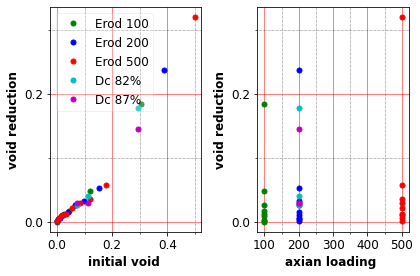

In [53]:
plt.rcParams.update({'font.size': 12})




#########################
fig5,(ax5e,ax5d)=plt.subplots(1,2)
# breakage of particle 
ax5d.plot(np.ones(len(t1_100[:-1]))*100,t2_100, color='green', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 100')
ax5d.plot(np.ones(len(t1_200[:-1]))*200,t2_200,color='b', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 200')
ax5d.plot(np.ones(len(t1_500[:-1]))*500,t2_500,color='r', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 500')
ax5d.plot(np.ones(len(t2_82))*200,t2_82,color='c', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 82')
ax5d.plot(np.ones(len(t2_87))*200,t2_87,color='m', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 82')
# ax5d.legend(loc='upper left',framealpha=0.25)
ax5d.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax5d.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax5d.set_ylabel('void reduction',fontweight='bold')
ax5d.set_xlabel('axian loading ',fontweight='bold')
# ax5d.set_ylim(-0.1,1)
ax5d.xaxis.set_major_locator(MultipleLocator(100))
ax5d.xaxis.set_minor_locator(MultipleLocator(50))
ax5d.yaxis.set_major_locator(MultipleLocator(0.2))
ax5d.yaxis.set_minor_locator(MultipleLocator(0.1))
# cumulative of voids 
ax5e.plot(t1_100[:-1],t2_100, color='green', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 100')
ax5e.plot(t1_200[:-1],t2_200,color='b', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 200')
ax5e.plot(t1_500[:-1],t2_500, color='r', marker="o", linestyle='-',linewidth=0, markersize=5, label='Erod 500')
ax5e.plot(t1_82[:-1],t2_82, color='c', marker="o", linestyle='-',linewidth=0, markersize=5, label='Dc 82%')
ax5e.plot(t1_87[:-1],t2_87, color='m', marker="o", linestyle='-',linewidth=0, markersize=5, label='Dc 87%')
ax5e.legend(loc='upper left',framealpha=0.25)
ax5e.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax5e.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax5e.set_ylabel('void reduction',fontweight='bold')
ax5e.set_xlabel('initial void ',fontweight='bold')
ax5e.xaxis.set_major_locator(MultipleLocator(0.2))
ax5e.xaxis.set_minor_locator(MultipleLocator(0.1))
ax5e.yaxis.set_major_locator(MultipleLocator(0.2))
ax5e.yaxis.set_minor_locator(MultipleLocator(0.1))

# voids vs cycle
# e_cy_100= e_cum_100[:-1]-e_cum_100[1:]
# e_cy_200= e_cum_200[:-1]-e_cum_200[1:]
# e_cy_1500= e_cum_500[:-1]-e_cum_500[1:]


fig5.tight_layout()
plt.show()


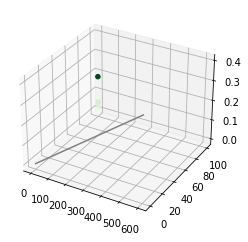

In [149]:
from scipy.optimize import curve_fit
def objective(x, a, b, c,d,e):
	return (a * x**3) + (b * x**4) + c*x**2 + d*x + e
popt,_ = curve_fit(objective,(voids, voids_reduction)

SyntaxError: unexpected EOF while parsing (<ipython-input-149-81009808274a>, line 4)

In [143]:
from scipy.optimize import curve_fit
def objective(x, a, b, c,d,e):
	return (a * x**3) + (b * x**4) + c*x**2 + d*x + e
popt,_ = curve_fit(objective,(voids, voids_reduction)
a, b, c,d,e = popt 
# three particle curve fitting 
min_x3, max_x3 = min(voids), max(voids)  
new_x3 = np.linspace(min_x3,max_x3,20)
new_y3=objective(new_x3, a3, b3, c3,d3,e3)
# ax4.plot(new_x3,new_y3,color='black', marker='o', linestyle='-',linewidth=2, markersize=0, label='Dense-3par')

SyntaxError: invalid syntax (<ipython-input-143-7399a761630f>, line 5)

In [123]:
voids_cy=np.concatenate([t1_100[1:-1],t1_200[1:-1],t1_500[1:-1],t1_82[1:-1],t1_87[1:-1]])
voids_reduction_cy=np.concatenate([t2_100[1:],t2_200[1:],t2_500[1:],t2_82[1:],t2_87[1:]])
load_cy=np.concatenate([np.ones(len(t2_100[1:]))*100,np.ones(len(t2_200[1:]))*200,np.ones(len(t2_500[1:]))*500,np.ones(len(t2_82[1:]))*200,np.ones(len(t2_87[1:]))*200])
voids_in=np.hstack([t1_100[0],t1_200[0],t1_500[0],t1_82[0],t1_87[0]])
voids_reduction_in=np.hstack([t2_100[0],t2_200[0],t2_500[0],t2_82[0],t2_87[0]]) 
load_in=np.hstack([100,200,500,200,200])  

In [119]:
voids_cy

array([0.1190056 , 0.0705856 , 0.0436856 , 0.0264696 , 0.0135576 ,
       0.0049496 , 0.0017216 , 0.0006456 , 0.178616  , 0.120512  ,
       0.083928  , 0.0538    , 0.03228   , 0.019368  , 0.008608  ,
       0.002152  , 0.11396265, 0.07301896])

# relative voids from NC line

# gekko moldel 
## import/data setting 


L_in_cy=np.concatenate([np.ones(len(e_cum_100[0:-1]))*100],[np.ones(len(e_cum_200[0:-1]))*200],[np.ones(len(e_cum_500[0:-1]))*500])
e_cy=np.concatenate([e_cum_100[0:-1]-e_cum_100[0],e_cum_200[0:-1]-e_cum_200[0],e_cum_500[0:-1]-e_cum_500[0]])
s_t_cy=np.concatenate([s_cum_100[1:],s_cum_200[1:],s_cum_500[1:]])

## define the variable 

xm1

# only cycle predition

In [124]:
from gekko import GEKKO
cof_e_cy=voids_cy
cof_e_in=voids_in
cof_load_cy=load_cy
cof_load_in=load_in
cof_ereduction_in=voids_reduction_in
cof_ereduction_cy = voids_reduction_cy


In [125]:
cof_e_cy

array([0.1190056 , 0.0705856 , 0.0436856 , 0.0264696 , 0.0135576 ,
       0.0049496 , 0.0017216 , 0.0006456 , 0.151716  , 0.097916  ,
       0.065636  , 0.038736  , 0.022596  , 0.011836  , 0.00538   ,
       0.001076  , 0.178616  , 0.120512  , 0.083928  , 0.0538    ,
       0.03228   , 0.019368  , 0.008608  , 0.002152  , 0.11396265,
       0.07301896, 0.11396265, 0.07301896])

 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  7
   Intermediates:  0
   Connections  :  0
   Equations    :  2
   Residuals    :  2
 
 Number of state variables:    31
 Number of total equations: -  28
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    3
 
 ----------------------------------------------
 Model Parameter Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  1.07776E+10  1.40672E-01
    1  5.82002E+11  5.55112E-17
    2  2.42050E+10  1.45398E-01
    3  2.01900E+08  1.46196E-01
    4  2.00443E+06  1.05085E-01
    5  1.19073E+04  3.49866E-03
    6  3.23736E+03  3.74996E-03
    7  3.31974E+03

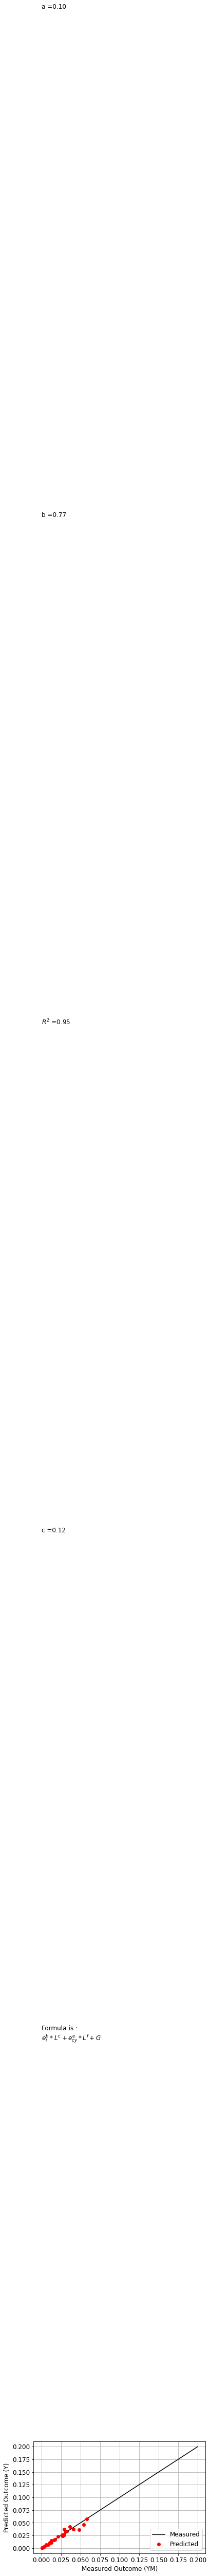

In [126]:
xm1 = np.array(cof_load_cy) # cumulative voids after the collapse not last one minus the collapse voids
xm2 = np.array(cof_e_cy)
ym3 = np.array(cof_ereduction_cy)

m3 = GEKKO(remote=False)

a = m3.FV(lb=0.1,ub=100.0)
b = m3.FV(lb=0.1,ub=100.0)
c = m3.FV(lb=0.1,ub=100.0)


x1 = m3.Param(value=xm1)
x2 = m3.Param(value=xm2)

z3 = m3.Param(value=ym3)
y3 = m3.Var()
m3.Equation(y3==c*(x1**a)*(x2**b))
m3.Minimize(((y3-z3)/z3)**2)
# Options

a.STATUS = 1
b.STATUS = 1
c.STATUS = 1


m3.options.IMODE = 2
m3.options.SOLVER = 1
# Solve
m3.solve(disp=True)

print('a: ', a.value[0])
print('b: ', b.value[0])
print('c: ', c.value[0])


# print('A: ', A.value[0])

##################################################################################################
cFormula = "Formula is : " + "\n" + \
           r"$e_i^b*L^c + e_{cy}^e*L^f + G $"

from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(ym3,y3)

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
# print(cR2)

# plot solution
plt.figure(1)
plt.plot([0,0.2],[0,0.2],'k-',label='Measured')
plt.plot(ym3,y3,'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

plt.text(0,5,'a =' + "{:.2f}".format(a.value[0])) 
plt.text(0,4,'b =' + "{:.2f}".format(b.value[0])) 
plt.text(0,2,'c =' + "{:.2f}".format(c.value[0])) 



plt.text(0,3,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"
cy_pre=y3


In [59]:
cof_e_in

array([0.3029756 , 0.38878   , 0.498536  , 0.29206767, 0.29206767])

 ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  0
   Constants    :  0
   Variables    :  7
   Intermediates:  0
   Connections  :  0
   Equations    :  2
   Residuals    :  2
 
 Number of state variables:    8
 Number of total equations: -  5
 Number of slack variables: -  0
 ---------------------------------------
 Degrees of freedom       :    3
 
 ----------------------------------------------
 Model Parameter Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  8.24682E+02  1.40650E-01
    1  7.89254E+03  2.77556E-17
    2  4.79342E-01  2.26669E-01
    3  7.86372E-02  1.05498E-01
    4  5.20316E-02  2.35290E-02
    5  5.01280E-02  1.01050E-03
    6  4.75353E-02  3.97959E-04
    7  4.14265E-02  

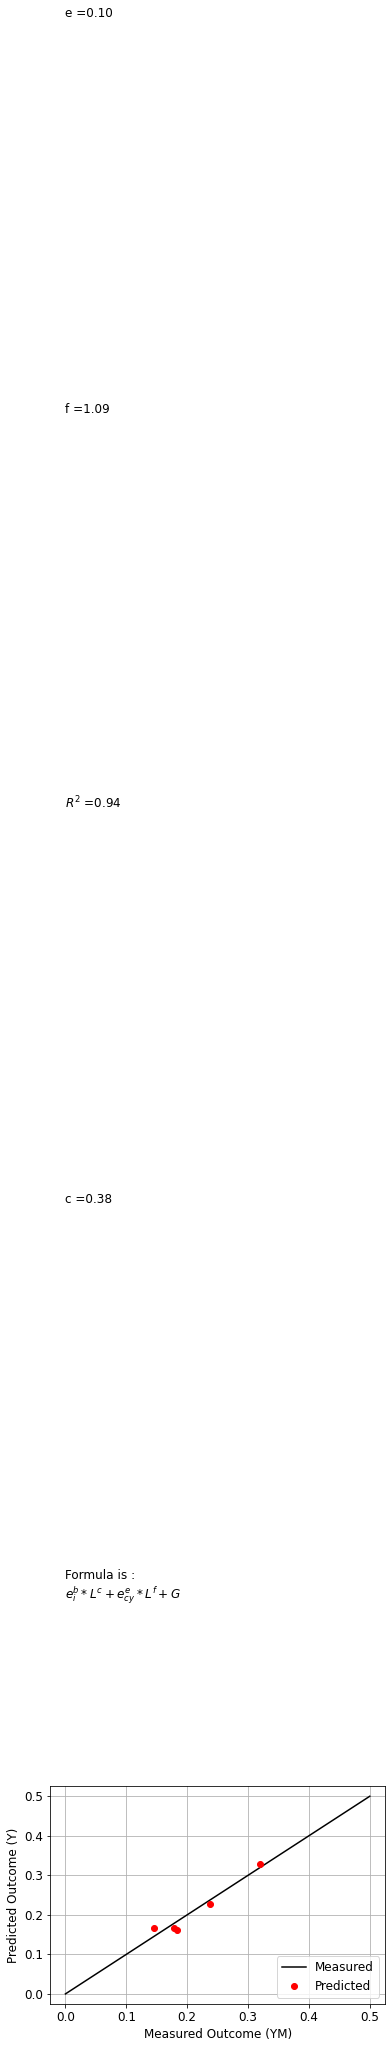

In [127]:

xm1 = np.array(cof_load_in) # cumulative voids after the collapse not last one minus the collapse voids
xm2 = np.array(cof_e_in)
ym4 = np.array(cof_ereduction_in)

m4 = GEKKO(remote=False)

e = m4.FV(lb=0.1,ub=100.0)
f = m4.FV(lb=0.1,ub=100.0)
g = m4.FV(lb=0.1,ub=100.0)


x1 = m4.Param(value=xm1)
x2 = m4.Param(value=xm2)

z4 = m4.Param(value=ym4)
y4 = m4.Var()
m4.Equation(y4==g*(x1**e)*(x2**f))
m4.Minimize(((y4-z4)/z4)**2)
# Options

e.STATUS = 1
f.STATUS = 1
g.STATUS = 1


m4.options.IMODE = 2
m4.options.SOLVER = 1
# Solve
m4.solve(disp=True)

print('e: ', e.value[0])
print('f: ', f.value[0])
print('g: ', g.value[0])


# print('A: ', A.value[0])

##################################################################################################
cFormula = "Formula is : " + "\n" + \
           r"$e_i^b*L^c + e_{cy}^e*L^f + G $"

from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(ym4,y4)

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
print(cR2)

# plot solution
plt.figure(1)
plt.plot([0,0.5],[0,0.5],'k-',label='Measured')
plt.plot(ym4,y4,'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

plt.text(0,5,'e =' + "{:.2f}".format(e.value[0])) 
plt.text(0,4,'f =' + "{:.2f}".format(f.value[0])) 
plt.text(0,2,'c =' + "{:.2f}".format(g.value[0])) 



plt.text(0,3,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"

In [111]:
pre_100=cy_pre[0:8]
pre_200=cy_pre[8:16]
pre_500=cy_pre[16:24]
pre_100.insert(0,y4[0])
pre_200.insert(0,y4[1])
pre_500.insert(0,y4[2])
pre_82=cy_pre[24:26]
pre_87=cy_pre[26:28]
pre_82.insert(0,y4[3])
pre_87.insert(0,y4[4])

In [114]:
pre_str_100=(np.cumsum(pre_100))/(1+t0_100[0])*100
pre_str_200=(np.cumsum(pre_200))/(1+t0_200[0])*100
pre_str_500=(np.cumsum(pre_500))/(1+t0_500[0])*100


In [113]:
pre_str_100,s_cum_100,t0_100,np.cumsum(pre_100)


(array([ 7.5814141 ,  9.26246849, 10.38745089, 11.16533477, 11.69450991,
        12.01086253, 12.15663367, 12.22134861, 12.25178956]),
 array([ 0.  ,  8.  , 10.25, 11.5 , 12.3 , 12.9 , 13.3 , 13.45, 13.5 ,
        13.53]),
 array([1.14229  , 0.95832  , 0.9099   , 0.883    , 0.865784 , 0.852872 ,
        0.844264 , 0.841036 , 0.83996  , 0.8393144]),
 array([0.16241588, 0.19842894, 0.22252932, 0.23919385, 0.25053032,
        0.25730751, 0.26043035, 0.26181673, 0.26246886]))

In [107]:
t0_100[0]

1.14229

NameError: name 'pre_strain' is not defined

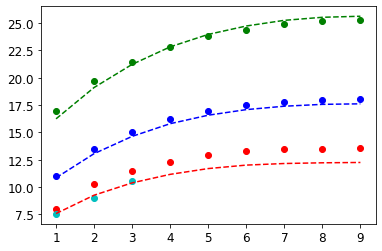

In [117]:
plt.figure()

plt.plot(np.linspace(1, 9,9),s_cum_100[1:],'ro',label='100 kpa Mas')
plt.plot(np.linspace(1, 9,9),s_cum_200[1:],'bo',label='200 kpa Mas')
plt.plot(np.linspace(1, 9,9),s_cum_500[1:],'go',label='500 kpa Mas')
plt.plot(np.linspace(1, 3,3),s_cum_87[1:],'co',label='82')
plt.plot(np.linspace(1, 9,9),np.cumsum(pre_100),'r--',label='100 kpa cal')
#plt.plot(np.linspace(1, 9,9),np.cumsum(pre_200),'b--',label='200 kpa cal')
plt.plot(np.linspace(1, 9,9),np.cumsum(pre_500),'g--',label='500 kpa cal')
plt.plot(np.linspace(1, 9,9),pre_strain(in_e_300,nc_e_300, 9, 300),'g-.',label='300 kpa cal')
plt.plot(np.linspace(1, 9,9),pre_strain(in_e_200,nc_e_200, 9, 200),'b-.',label='200 kpa cal')
plt.plot(np.linspace(1, 3,3),pre_strain(in_e_82,nc_e_82, 3, 200),'b-.',label='200 kpa cal')
pre_strain(in_e_300,nc_e_300, 9, 300)
plt.xlabel('Dry/Wet cycle')
plt.ylabel('Vertical strain(%)')
plt.legend(loc='best',framealpha=0.25,ncol=2)

plt.grid(True)
plt.show()

from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200))

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
print(cR2)

# plot solution
plt.figure(1)
plt.plot([10,18],[10,18],'k-',label='Measured')
plt.plot(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200),'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

# plt.text(0,5,'e =' + "{:.2f}".format(e.value[0])) 
# plt.text(0,4,'f =' + "{:.2f}".format(f.value[0])) 
# plt.text(0,2,'c =' + "{:.2f}".format(c.value[0])) 



plt.text(10,16,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
# plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
# cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"

# prediction of 300 kpa

In [87]:
(s_cum_200[1:]),np.array(pre_strain(in_e_200,nc_e_200, 9, 200)),r_value

(array([11.  , 13.5 , 15.  , 16.25, 17.  , 17.5 , 17.8 , 18.  , 18.05]),
 array([10.66683115, 11.96796393, 12.91382583, 13.57579312, 14.01671894,
        14.29121552, 14.44594379, 14.51990741, 14.54472469]),
 0.9996568769892696)

R^2 correlation = 0.9993138717119397


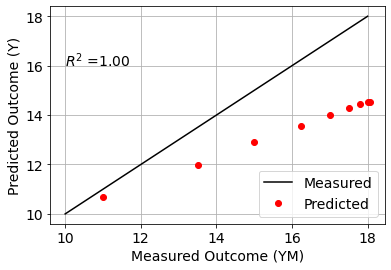

'$D * Voids^E * Load^f + G$'

In [88]:
from scipy import stats
slope, intercept, r_value, p_value, \
       std_err = stats.linregress(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200))

r2 = r_value**2
cR2 = "R^2 correlation = " + str(r_value**2)
print(cR2)

# plot solution
plt.figure(1)
plt.plot([10,18],[10,18],'k-',label='Measured')
plt.plot(s_cum_200[1:],pre_strain(in_e_200,nc_e_200, 9, 200),'ro',label='Predicted')
plt.xlabel('Measured Outcome (YM)')
plt.ylabel('Predicted Outcome (Y)')
plt.legend(loc='lower right')

# plt.text(0,5,'e =' + "{:.2f}".format(e.value[0])) 
# plt.text(0,4,'f =' + "{:.2f}".format(f.value[0])) 
# plt.text(0,2,'c =' + "{:.2f}".format(c.value[0])) 



plt.text(10,16,r'$R^2$ =' + "{:.2f}".format(r_value**2)) 
# plt.text(0,1,cFormula)
plt.grid(True)
plt.show()
# cFormula = "Formula is : " + "\n" + \
r"$D * Voids^E * Load^f + G$"

In [97]:
df4=pd.read_excel(r"C:\Users\ThinkCentre-M73\Desktop\master 2\python link file\voids vs load.xlsx")
in_e_300=np.interp(300,df4["loading"],df4["voids-load"])
nc_e_300=np.interp(300,[200,500],[t0_200[-1],t0_500[-1]])
no_cycle=9
load=300

In [99]:
in_e_200=np.interp(200,df4["loading"],df4["voids-load"])
nc_e_200=0.7162
no_cycle=9
load=200

In [100]:
in_e_82=df3['e-82%'][0]
nc_e_82=0.7162
no_cycle=3
load=200

In [115]:
in_e_82,in_e_200

(1.0082876712328768, 1.1057963871128824)

In [102]:
def pre_strain (in_e,nc_e,no_cycle,load):
    strain_pre=[]
    
    # initial strain
    str_in=load**0.47*(in_e-nc_e)**0.1
    strain_pre.insert(0,str_in)
    ini1=[]
    ini=in_e*(1-((str_in)/100))-(str_in)/100
    for i in range(no_cycle-1):
        strain_pre.append(strain_pre[i]+5.61*load**0.1*(ini-nc_e)**0.78)
        ini=in_e*(1-((strain_pre[i+1])/100))-(strain_pre[i+1])/100
        ini1.append(in_e*(1-(strain_pre[i+1])/97)-(strain_pre[i+1])/97)
    return strain_pre
        
        
    


In [66]:
e_cum_87

array([0.29206767, 0.42036061, 0.50770986, 0.56844572])

In [64]:
pre_strain(in_e_300,nc_e_300, 9, 300)

[13.401325030648058,
 15.628787213506534,
 17.28868164258405,
 18.487238840716067,
 19.318845016535125,
 19.866416040113617,
 20.201781719586105,
 20.386079799022347,
 20.470153736258087]

In [757]:
pre_strain(in_e_200,nc_e_200, 9, 200)

[9.550003401525537,
 11.39681583861104,
 12.76429824238251,
 13.741724572258477,
 14.409114288919849,
 14.837393893532422,
 15.088560265145636,
 15.215840743071917,
 15.263817474909589]

In [921]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(pre_strain(in_e_200,nc_e_200, 9, 200),s_cum_200[1:]) 

In [922]:
coefficient_of_dermination

0.9908735083555548